In [1]:
#pip install easyocr

In [104]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import visualkeras

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D

In [45]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [46]:
import json

# ------------------------------------------------------------------------------------------

# Import image data

In [7]:
train_path= "/Users/pimawatmingkwan/Desktop/DataSci_practice/benetech-making-graphs-accessible/train/images"
test_path= "/Users/pimawatmingkwan/Desktop/DataSci_practice/benetech-making-graphs-accessible/test/images"

In [8]:
x_train=[]

for folder in os.listdir(train_path):
    if folder != ".DS_Store" :
        sub_path=train_path+"/"+folder
        image_path=sub_path
        img_arr=cv2.imread(image_path)
        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):
    if folder != ".DS_Store" :
        sub_path=test_path+"/"+folder
        image_path=sub_path
        img_arr=cv2.imread(image_path)
        x_test.append(img_arr)

In [9]:
img_file_name_ls = os.listdir(train_path)

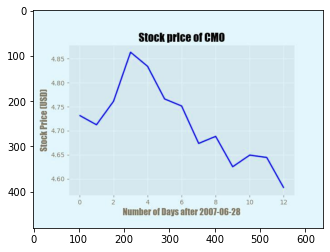

In [10]:
plt.imshow(x_train[3])
plt.show()

In [11]:
train_anno_path= "/Users/pimawatmingkwan/Desktop/DataSci_practice/benetech-making-graphs-accessible/train/annotations"

In [12]:
f = open ('/Users/pimawatmingkwan/Desktop/DataSci_practice/benetech-making-graphs-accessible/train/annotations/e91e28111e86.json', "r")

In [13]:
data = json.loads(f.read())

In [14]:
f = open ('/Users/pimawatmingkwan/Desktop/DataSci_practice/benetech-making-graphs-accessible/train/annotations/75c0449f6917.json', "r")

In [15]:
data = json.loads(f.read())

In [16]:
x_anno_train=[]

for folder in os.listdir(train_anno_path):
    if folder != ".DS_Store" :
        sub_path=train_anno_path+"/"+folder
        anno_path=sub_path
        f = open (anno_path, "r")
        anno = json.loads(f.read())
        x_anno_train.append(anno)

In [17]:
anno_file_name_ls = os.listdir(train_anno_path)

In [18]:
anno_df = pd.DataFrame({'anno_file_name' : anno_file_name_ls,
                                'anno' : x_anno_train }, 
                                columns=['anno_file_name','anno'])

In [19]:
anno_df.head()

,anno_file_name,anno
0,e91e28111e86.json,"{'source': 'generated', 'chart-type': 'scatter..."
1,75c0449f6917.json,"{'source': 'generated', 'chart-type': 'vertica..."
2,66dd2a250237.json,"{'source': 'generated', 'chart-type': 'scatter..."
3,58595c30beab.json,"{'source': 'generated', 'chart-type': 'vertica..."
4,497a547454d7.json,"{'source': 'generated', 'chart-type': 'scatter..."


In [20]:
anno_df['id'] = anno_df.apply(lambda x: x['anno_file_name'].replace('.json',''),axis=1)

In [21]:
img_df = pd.DataFrame({'img_file_name' : img_file_name_ls}, 
                                columns=['img_file_name'])

In [22]:
img_df.head()

,img_file_name
0,45df1fe3293b.jpg
1,b2ab3b743d4e.jpg
2,51d3b1a6baf3.jpg
3,a9e9ce9277c1.jpg
4,7f1f545fe081.jpg


In [23]:
img_df['id'] = img_df.apply(lambda x: x['img_file_name'].replace('.jpg',''),axis=1)

In [24]:
mix_df = pd.merge(img_df, anno_df, how="left", on=["id"])

In [25]:
anno_ls = list(mix_df['anno'])

# Use x_train for image and anno_ls for annotation list

In [26]:
anno_ls[0]['plot-bb']['height']

165

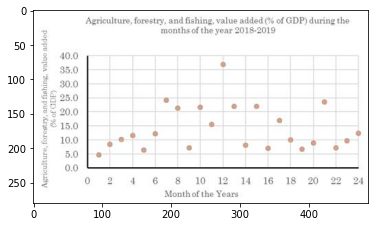

In [27]:
plt.imshow(x_train[0])

In [28]:
type(anno_ls[0])

dict

In [29]:
len(anno_ls)

60578

In [30]:
len(x_train)

60578

# Extract data from dict

- source /
- chart type /
- height /
- width /
- x0 /
- y0 /
- chart title / 
- x title /
- y title /
- data-series 
- x value 
- y value 

In [31]:
source_ls = []
chart_type_ls = []
height_ls = []
width_ls = []
x0_ls = []
y0_ls = []
chart_title_ls = []
x_title_ls = []
y_title_ls = []
data_series_ls = []
x_value_ls = []
y_value_ls = []

for chart_info_dict in anno_ls:
    source = chart_info_dict['source']
    chart_type = chart_info_dict['chart-type']
    h = chart_info_dict['plot-bb']['height']
    w = chart_info_dict['plot-bb']['width']
    x0 = chart_info_dict['plot-bb']['x0']
    y0 = chart_info_dict['plot-bb']['y0']
    chart_title = chart_info_dict['text'][0]['text']
    x_title = chart_info_dict['text'][1]['text']
    y_title = chart_info_dict['text'][2]['text']
    
    x_value = []
    for i in chart_info_dict['data-series'] :
        x_value.append(i['x'])
    
    y_value = []
    for i in chart_info_dict['data-series'] :
        y_value.append(i['y'])
        
    source_ls.append(source)
    chart_type_ls.append(chart_type)
    height_ls.append(h)
    width_ls.append(w)
    x0_ls.append(x0)
    y0_ls.append(y0)
    chart_title_ls.append(chart_title)
    x_title_ls.append(x_title)
    y_title_ls.append(y_title)
    x_value_ls.append(x_value)
    y_value_ls.append(y_value)


In [32]:
master_anno_df = pd.DataFrame({'id' : list(mix_df['id']),
                    'source' : source_ls, 
                    'chart_type' : chart_type_ls,
                    'height' : height_ls,
                    'width' : width_ls,
                    'x0' : x0_ls, 
                    'y0' : y0_ls,
                    'chart_title' : chart_title_ls,
                    'x_title' : x_title_ls,
                    'y_title' : y_title_ls, 
                    'x_value' : x_value_ls,
                    'y_value' : y_value_ls})

In [33]:
master_anno_df.head()

,id,source,chart_type,height,width,x0,y0,chart_title,x_title,y_title,x_value,y_value
0,45df1fe3293b,generated,scatter,165,396,78,65,"Agriculture, forestry, and fishing, value adde...","Agriculture, forestry, and fishing, value adde...",Month of the Years,"[1.0025687455257515, 2.0213079546890143, 3.015...","[4.865904260702349, 8.557838275478183, 10.2094..."
1,b2ab3b743d4e,generated,vertical_bar,145,384,92,34,"Share of cereals allocated to food (FAO, 2020)...",COUNTRY,"SHARE OF CEREALS ALLOCATED TO FOOD (FAO, 2020)","[Italy, Jamaica, Japan, Jordan, Kazakhstan, Ke...","[80.40816326530613, 88.57142857142857, 90.2040..."
2,51d3b1a6baf3,extracted,scatter,345,384,102,76,Price Phillips curve 1960-2003,Employment rate,Price inflation (first differences),"[0.9026008929732542, 0.903745285881486, 0.9152...","[-0.025066589461493913, 0.009849449913144195, ..."
3,a9e9ce9277c1,generated,line,332,497,80,79,Stock price of CMO,Number of Days after 2007-06-28,Stock Price (USD),"[0, 2, 4, 6, 8, 10, 12]","[4.7324757996633, 4.7676552456382, 4.835736905..."
4,7f1f545fe081,generated,scatter,159,385,61,67,"Sex ratio by age (100 year olds) (UNWPP , 2017...",Sex ratio,Years,"[1989.9980527067376, 1991.0431000908736, 1991....","[21.879962192816635, 21.879962192816635, 21.97..."


# Annotations dataframe

In [34]:
final_df = master_anno_df.loc[:, ['id','chart_type','x_value','y_value']]

In [35]:
final_df.head(10)

,id,chart_type,x_value,y_value
0,45df1fe3293b,scatter,"[1.0025687455257515, 2.0213079546890143, 3.015...","[4.865904260702349, 8.557838275478183, 10.2094..."
1,b2ab3b743d4e,vertical_bar,"[Italy, Jamaica, Japan, Jordan, Kazakhstan, Ke...","[80.40816326530613, 88.57142857142857, 90.2040..."
2,51d3b1a6baf3,scatter,"[0.9026008929732542, 0.903745285881486, 0.9152...","[-0.025066589461493913, 0.009849449913144195, ..."
3,a9e9ce9277c1,line,"[0, 2, 4, 6, 8, 10, 12]","[4.7324757996633, 4.7676552456382, 4.835736905..."
4,7f1f545fe081,scatter,"[1989.9980527067376, 1991.0431000908736, 1991....","[21.879962192816635, 21.879962192816635, 21.97..."
5,16f80d955922,line,"[Afghanistan, African Region (WHO), Albania, A...","[202.67688822016396, 92.28886331138378, 112.07..."
6,d7f597a3b9c9,scatter,"[1990.086239456125, 1991.0430567795543, 1992.0...","[32.5765458422175, 34.62345415778253, 35.85159..."
7,81cd889afde3,scatter,"[1949.7359666484188, 1954.688171137407, 1959.7...","[53.85063449136675, 56.90867484917827, 64.3353..."
8,7842fc1bff9c,line,"[Afghanistan, Albania, Algeria, Andorra, Angol...","[105.03069612884842, 108.16244412181692, 104.8..."
9,a02f2b67a8c1,vertical_bar,"[Jackson, Kalamazoo, Kalkaska, Kent, Keweenaw,...","[12.44636585289724, 12.44636585289724, 18.2811..."


In [36]:
final_df['chart_type'].value_counts()

line              24942
vertical_bar      19189
scatter           11243
dot                5131
horizontal_bar       73
Name: chart_type, dtype: int64

# ------------------------------Simple OCR Network------------------------------------

In [37]:
import cv2
#import easyocr
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from pprint import pprint

In [38]:
pprint(anno_ls[0])

{'axes': {'x-axis': {'tick-type': 'markers',
                     'ticks': [{'id': 3, 'tick_pt': {'x': 78, 'y': 230}},
                               {'id': 4, 'tick_pt': {'x': 111, 'y': 230}},
                               {'id': 5, 'tick_pt': {'x': 144, 'y': 230}},
                               {'id': 6, 'tick_pt': {'x': 177, 'y': 230}},
                               {'id': 7, 'tick_pt': {'x': 210, 'y': 230}},
                               {'id': 8, 'tick_pt': {'x': 243, 'y': 230}},
                               {'id': 9, 'tick_pt': {'x': 276, 'y': 230}},
                               {'id': 10, 'tick_pt': {'x': 309, 'y': 230}},
                               {'id': 11, 'tick_pt': {'x': 342, 'y': 230}},
                               {'id': 12, 'tick_pt': {'x': 375, 'y': 230}},
                               {'id': 13, 'tick_pt': {'x': 408, 'y': 230}},
                               {'id': 14, 'tick_pt': {'x': 441, 'y': 230}},
                               {'id': 15, 'tick_pt'

In [39]:
img_index = 4799

annotation = anno_ls[img_index]
image = x_train[img_index]

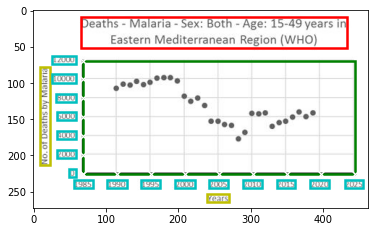

In [40]:
color_dict ={
    "chart_title": "r",
    "axis_title": "y",
    "tick_label": "c"
}

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,15)

# === Plot text bounding boxes ===
for i in range(len(annotation["text"])):
    role = annotation["text"][i]["role"]
    x0 = annotation["text"][i]["polygon"]["x0"]
    y0 = annotation["text"][i]["polygon"]["y0"]
    H = annotation["text"][i]["polygon"]["x1"] - x0
    W = annotation["text"][i]["polygon"]["y2"] - y0
    rect = patches.Rectangle((x0, y0), H, W,
                             linewidth=2.5,
                             edgecolor=color_dict[role], facecolor='none')
    ax.add_patch(rect) 

# === Plot axis ticks ===
for axis in annotation["axes"].keys():
    for j in range(len(annotation["axes"][axis]["ticks"])):
        tick_point = annotation["axes"][axis]["ticks"][j]['tick_pt']
        plt.plot(tick_point["x"],tick_point["y"],'wx') 
        
# === Plot axis ticks ===
for axis in annotation["axes"].keys():
    for j in range(len(annotation["axes"][axis]["ticks"])):
        tick_point = annotation["axes"][axis]["ticks"][j]['tick_pt']
        plt.plot(tick_point["x"],tick_point["y"],'wx') 
        
plot_bb = annotation["plot-bb"]
rect = patches.Rectangle((plot_bb["x0"], plot_bb["y0"]),
                          plot_bb["width"], plot_bb["height"],
                          linewidth=2.5, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Display the image
ax.imshow(image)
plt.show()

# ------------------------------------------------------------------------------------------

# Image processing before train image classification model

In [52]:
# use only 500 image (limitation of calculation on macbook)

In [49]:
final_df[final_df['chart_type']=='horizontal_bar'].head()

,id,chart_type,x_value,y_value
40,45eab7a55c20,horizontal_bar,"[90, 40, 80, 40, 60]","[Music, Maths, History, English, Science]"
357,157d1028b7b2,horizontal_bar,"[3, 5, 7, 7, 10, 11, 14, 24, 27, 28, 38, 74]","[Algae, Mosses, Lichens, Bats, Fish, Fungi, Al..."
404,d9293f1ffdb5,horizontal_bar,"[47.05882352941176, 46.57534246575342, 36.6639...","[Sweets, Chips and crisps, Sugar, Oils and fat..."
526,150bda2d06ba,horizontal_bar,"[6.085964244960065, 10.650437428680112, 8.6534...","[High income, Upper middle income, Lower middl..."
1080,5ac507f73eb4,horizontal_bar,"[90, 40, 80, 40, 60]","[Music, Maths, History, English, Science]"


In [53]:
x_train = x_train[:500]
final_df = final_df[:500]

In [54]:
for i in range(len(x_train)):
    x_train[i] = resize(x_train[i],(100,100))

In [55]:
train_x=np.array(x_train)

In [56]:
train_x.shape

(500, 100, 100, 3)

In [57]:
final_df['chart_type_for_train'] = final_df.apply(lambda x: int(x['chart_type'].replace('line','0')
                                                  .replace('vertical_bar','1')
                                                 .replace('scatter','2')
                                                 .replace('dot','3')
                                                 .replace('horizontal_bar','4')),axis=1)

In [58]:
final_df.loc[:, ['id','chart_type','chart_type_for_train']].head(20)

,id,chart_type,chart_type_for_train
0,45df1fe3293b,scatter,2
1,b2ab3b743d4e,vertical_bar,1
2,51d3b1a6baf3,scatter,2
3,a9e9ce9277c1,line,0
4,7f1f545fe081,scatter,2
5,16f80d955922,line,0
6,d7f597a3b9c9,scatter,2
7,81cd889afde3,scatter,2
8,7842fc1bff9c,line,0
9,a02f2b67a8c1,vertical_bar,1


In [59]:
train_y = np.array(list(final_df['chart_type_for_train']))

In [60]:
train_y

array([2, 1, 2, 0, 2, 0, 2, 2, 0, 1, 2, 2, 3, 2, 1, 1, 2, 0, 0, 0, 0, 1,
       2, 2, 2, 3, 0, 0, 0, 2, 1, 1, 1, 3, 0, 0, 1, 2, 2, 1, 4, 0, 2, 0,
       3, 0, 1, 2, 1, 1, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 3,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 3, 0, 0, 0, 0,
       0, 1, 2, 2, 2, 0, 0, 0, 3, 1, 1, 0, 0, 0, 3, 0, 2, 1, 2, 0, 0, 1,
       0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 3, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 3,
       2, 1, 3, 1, 1, 3, 1, 0, 3, 2, 2, 1, 2, 2, 0, 1, 3, 0, 0, 1, 0, 2,
       2, 0, 0, 3, 1, 1, 3, 1, 2, 3, 0, 0, 2, 0, 0, 3, 0, 0, 1, 1, 3, 0,
       3, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 3, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 3, 0, 1, 3, 1, 1, 1, 1, 2, 0, 1, 1,
       0, 2, 3, 3, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0,
       2, 1, 1, 3, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 1, 3, 1, 1, 1, 3, 2, 0,
       0, 2, 0, 2, 3, 2, 3, 1, 3, 0, 0, 1, 2, 1, 1,

# Model creation

In [147]:
model = Sequential()
model.add(Conv2D(10, kernel_size=2, activation='relu',input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [141]:
model = Sequential() 
model.add(Flatten(input_shape=(100, 100, 3))) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(5, activation='softmax'))

In [133]:
model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(100, 100, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])

In [148]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [149]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 99, 99, 10)        130       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 49, 49, 10)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 24010)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 120055    
Total params: 120,185
Trainable params: 120,185
Non-trainable params: 0
_________________________________________________________________


In [150]:
history = model.fit(train_x, train_y,batch_size=5,validation_split=0.2,epochs=5)

Epoch 1/5


ValueError: in user code:

    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/pimawatmingkwan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (5, 1) and (5, 5) are incompatible


# Model Evaluation

In [ ]:
score = model.evaluate(train_x, train_y, verbose = 3)

In [ ]:
score

In [ ]:
predictions = model.predict_classes(test_x, verbose = 1)

In [ ]:
confusion_matrix = confusion_matrix(test_y, predictions)

In [ ]:
confusion_matrix